In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from astropy.io import fits
import os

In [2]:
def basic_figure_style():
    SMALL_SIZE = 5*4                                       
    MEDIUM_SIZE = 8*2
    BIGGER_SIZE = 10*4

    plt.rc('font', size=MEDIUM_SIZE, family='serif')          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)                     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE, direction='out')    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE, direction='out')    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)                    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
    plt.rc('lines', linewidth=3) 
    plt.rc('axes', grid=True) #
    plt.rc('grid', alpha=0.7) #
    plt.rc('xtick', top=True)
    plt.rc('ytick', right=True)
    plt.rc('axes.formatter', use_mathtext=True, min_exponent=4, useoffset=False)
    plt.rc('figure', figsize='6, 6')                         # size of the figure, used to be '4, 3' in inches
    ######################################################
basic_figure_style()


# 1. create sb image of suzaku based on fitted double beta (no bkg) profile

define models

In [3]:
def DoubleBeta(x, beta, rc1, rc2, ratio, norm, const):
    out = np.power(10,norm) * (np.power(1 + (x / rc1) **2, -3 * beta + 0.5) + ratio * np.power(1 + (x / rc2) **2, -3 * beta + 0.5)) + np.power(10,const)
    return out
def DoubleBeta_nobkg(x, beta, rc1, rc2, ratio, norm):
    out = np.power(10,norm) * (np.power(1 + (x / rc1) **2, -3 * beta + 0.5) + ratio * np.power(1 + (x / rc2) **2, -3 * beta + 0.5)) 
    return out
def BetaModel(x, beta, rc, norm,const):
    out = np.power(10,norm) * np.power(1. + (x / rc) ** 2, -3. * beta + 0.5) + np.power(10,const)
    return out

create sb profile image in suzaku

center_i,center_j : 116 62


100%|██████████| 192/192 [00:00<00:00, 1143.52it/s]


center_i,center_j : 80 136


100%|██████████| 192/192 [00:00<00:00, 1132.47it/s]


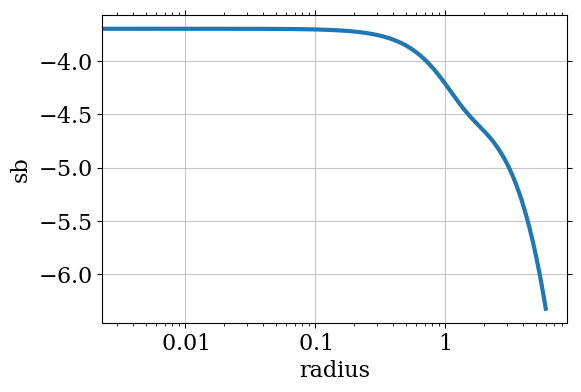

<Figure size 600x600 with 0 Axes>

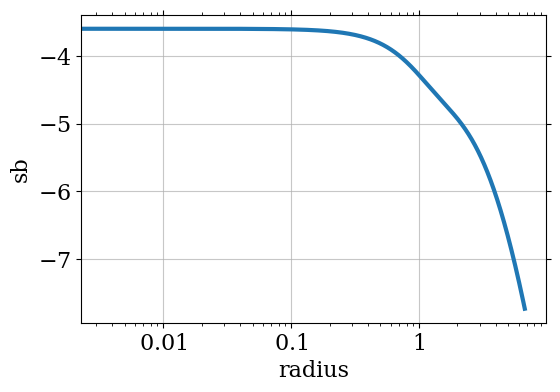

<Figure size 600x600 with 0 Axes>

In [9]:
workdir = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/xissim/230319'

datapath = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/results_230305'
os.chdir(workdir)
# a222
radec_lst = {'A222':[24.3941937,-12.9933436], "A223":[24.4830446,-12.8203439]}
# at 0.5-7 keV band
rs = {'A222':1.2*5, "A223":1.2*5.6}
clus = 'A222'
with fits.open(f'{workdir}/{clus}_0.5-7_chan_Doublebeta_nobkg.fits') as hdul:
    sum_data = np.zeros(hdul[0].data.shape)
for clus in ['A222', 'A223']:
    file = glob(f'{datapath}/{clus}*chan*0.5-7*doublebeta*profile.fits')[0]
    annu = np.arange(rs[clus],step=1/300)
    hdul = fits.open(file)
    mdl = hdul[2].data
    sb = DoubleBeta_nobkg(annu, mdl['VALUE'][0], mdl['VALUE'][1], mdl['VALUE'][2], mdl['VALUE'][3], mdl['VALUE'][4])
    fig, ax = plt.subplots(1, 1, figsize = (6, 4))
    plt.plot(annu,np.log10(sb))
    plt.xscale('log')
    plt.xlabel('radius')
    plt.ylabel('sb')
    # convert radec to ij (image)
    crval1 = 24.4438
    crval2 = -12.9141
    cdelt1 = -2.316e-3
    cdelt2 = 2.316e-3
    crpix1 = 96.5
    crpix2 = 96.5
    img = np.zeros((192,192))
    def radec2ij(ra,dec):
        i = (ra - crval1)*np.cos(crval2)/cdelt1+crpix2 
        j = (dec - crval2)/cdelt2+crpix1
        return i,j
    ic,jc = radec2ij(radec_lst[clus][0],radec_lst[clus][1])
    print("center_i,center_j :",int(ic),int(jc))
    annu_pix = annu/60/cdelt2
    [i_arr, j_arr, sb_arr] = [[] for i in range(3)]
    for i in tqdm(range(len(img[0]))):
        for j in range(len(img[1])):
            r = np.sqrt((i-int(ic))**2+(j-int(jc))**2)
            inds = np.digitize(r,annu_pix)
            if inds<=len(annu_pix)-1:
                img[i][j] = (sb[inds]+sb[inds-1])/2
                i_arr.append(i)
                j_arr.append(j)
                sb_arr = (sb[inds]+sb[inds-1])/2
            else:
                img[i][j] = 0


    fig2 = plt.figure(figsize=(6, 6))
    # plt.imshow(np.log10(img.T),origin="lower") #,extent=[0,192,0,192]
    os.system(f'cp {workdir}/../xissim_230306/{clus}_0.5-7_chan_Doublebeta_nobkg.fits {clus}_0.5-7_chan_Doublebeta_nobkg.fits')
    with fits.open(f'{workdir}/{clus}_0.5-7_chan_Doublebeta_nobkg.fits', mode='update') as hdul:
        hdul[0].data = img.T
        hdul.flush()
    sum_data += img.T
os.system(f'cp {workdir}/../xissim_230306/SUM_0.5-7_chan_Doublebeta_nobkg.fits SUM_0.5-7_chan_Doublebeta_nobkg.fits')
with fits.open(f'{workdir}/SUM_0.5-7_chan_Doublebeta_nobkg.fits', mode='update') as hdul:
    hdul[0].data = sum_data
    hdul.flush()

check the xissim sb input images 

(192, 192)
4
4


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 55557.465486 from DATE-END'. [astropy.wcs.wcs]
/var/folders/sy/vxhnb6x11wz6mkt7x_sw_y140000gn/T/ipykernel_483/60373988.py:28: RuntimeWarning: divide by zero encountered in log10
  image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)


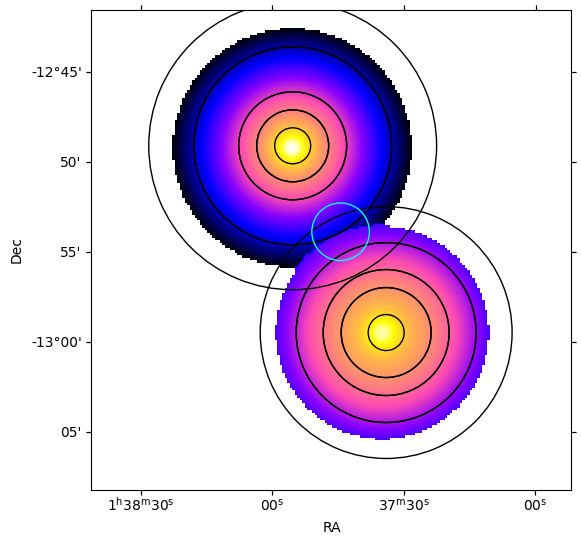

<Figure size 640x480 with 0 Axes>

In [44]:
# from astropy.visualization import astropy_mpl_style
import matplotlib.colors as colors
# plt.style.use(astropy_mpl_style)
plt.style.use('default')
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
import pyregion

from matplotlib.patches import Annulus, Circle

kernel = Gaussian2DKernel(x_stddev=1)
# 'EPN_corr_counts'
clus = 'SUM'
file = f"{workdir}/{clus}_0.5-7_chan_Doublebeta_nobkg.fits"
hdu = fits.open(f'{file}')[0]
image_data = hdu.data
print(image_data.shape)
fig= plt.figure(figsize = (6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=WCS(f'{file}'))
ra = ax.coords[0]
dec = ax.coords[1]
# plt.grid(color='grey', ls='dashed')
plt.grid('off')
ra.set_axislabel('RA')
dec.set_axislabel('Dec')
image_data = np.where(np.isfinite(np.log10(image_data)), image_data, np.nan)
# astropy_conv = convolve(image_data, kernel)

plt.imshow(image_data, cmap='gnuplot2', norm = colors.LogNorm(), origin='lower')

# plot regions
centers = {'A222':(117.37057,62.28223),'A223':(79.977412,136.98069)}
annu_rs = {'A222':(7.1963155,17.990789,25.187104,35.981577,50.374208),'A223':(7.1963155,14.392631,21.588946,39.579735,57.570524)}
for clus in ['A222', 'A223']:
    print(len(annu_rs[clus])-1)
    for i in range(len(annu_rs[clus])-1):
        annu = Annulus(centers[clus], annu_rs[clus][i+1], annu_rs[clus][i+1]-annu_rs[clus][i], fill=False, edgecolor='k')
        ax.add_patch(annu)
werner_16 = Circle((99.151553,102.58805),11.514105, fill=False, edgecolor = 'cyan')
ax.add_patch(werner_16)
# plt.colorbar()

plt.savefig(f'{file.split(".")[0]}.pdf', dpi=300)
plt.show()
plt.clf()


# 2. run xissim

In [11]:
workdir = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/xissim/230319'
os.makedirs('region', exist_ok=True)
os.makedirs('evts', exist_ok=True)
os.makedirs('qdps', exist_ok=True)
os.makedirs('photons', exist_ok=True)
os.makedirs('pdf', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('spec_regions', exist_ok=True)

1. cut profile.fits to annulus 

In [24]:


for clus in A222 A223
do
for y in 1 2 
do
export root=annu_${clus}_${y}
ftimgcalc region/${root}.fits 'regfilter("region/${root}.reg",A.P1,A.P2) ? (1):(0)' a=A222_0.5-7_chan_Doublebeta_nobkg.fits clobber=yes
farith ${clus}_0.5-7_chan_Doublebeta_nobkg.fits region/${root}.fits ${clus}_${root}_inputimg.fits  "*" clobber=yes
done
done


2. save apec mdl as .qdp file, for 0.5-7 keV

In [ ]:
cp /Users/eusracenorth/Documents/suzaku_A222-223/suzaku_data/xissim/230106/a22*_apec.csv .

2. change the T and n csv

In [5]:
workdir = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/xissim/230319'
os.chdir(workdir)
f = open(f'{workdir}/logs/T_n.logs')
lines = f.readlines()
i =0
Ts = np.zeros(3*3*2+3)
Terr = np.zeros(3*3*2+3)
ns = np.zeros(3*3*2+3)
nerr = np.zeros(3*3*2+3)
for j, line in enumerate(lines):
    if 'kT' in line:   
        Ts[i] =  float(line.split('keV')[-1].split('+/-')[0])
        Terr[i] =  float(line.split('keV')[-1].split('+/-')[-1] )
        ns[i] =  float(lines[j+1].split('norm')[-1].split('+/-')[0])
        nerr[i] =  float(lines[j+1].split('norm')[-1].split('+/-')[-1])
        i +=1
f.close()

for k, i in enumerate([2,3]):
    newf = open(f'a22{i}_const_apec.csv', 'w')
    newf.write(f'region, T, n, Tlo, nlo, Thi, nhi\n')
    for j, region in enumerate([f'annu_A22{i}_1', f'annu_A22{i}_2']):
        newf.write(f'{region}, {Ts[k*9+j*3]}, {ns[k*9+j*3]},\
{Ts[k*9+j*3+1]-Terr[k*9+j*3+1]},  {ns[k*9+j*3+1]-nerr[k*9+j*3+1]}, \
{Ts[k*9+j*3+2]+Terr[k*9+j*3+2]}, {ns[k*9+j*3+2]+nerr[k*9+j*3+2]}\n')
newf.close()

In [21]:
rm inputs/*T*
for j in 2 3
do
for i in 2 3 
do
export root=a22${j}_const_apec
head -n ${i} ${root}.csv | tail -n 1| cut -d , -f 2 | read T
head -n ${i} ${root}.csv | tail -n 1| cut -d , -f 3 | read n
export i=$(expr ${i} - 1)
export output=inputs/a22${j}_tbabs_apec_annu_${i}_T
xspec << EOT
log >${output}.log
mo tbabs*apec
0.0162
${T}
0.3
0.21
${n}
flux 0.6 7
ipl mo
we ${output}
log none
exit
exit
no
EOT
done
done

rm inputs/*Tlo*
for j in 2 3
do
for i in 2 3
do
export root=a22${j}_const_apec
head -n ${i} ${root}.csv | tail -n 1| cut -d , -f 4 | read T
head -n ${i} ${root}.csv | tail -n 1| cut -d , -f 5 | read n
export i=$(expr ${i} - 1)
export output=inputs/a22${j}_tbabs_apec_annu_${i}_Tlo
xspec << EOT
log >${output}.log
mo tbabs*apec
0.0162
$T
0.3
0.21
$n
flux 0.6 7
ipl mo
we ${output}
log none
exit
exit
no
EOT
done
done

for j in 2 3
do
for i in 2 3 
do
export root=a22${j}_const_apec
head -n ${i} ${root}.csv | tail -n 1| cut -d , -f 6 | read T
head -n ${i} ${root}.csv | tail -n 1| cut -d , -f 7 | read n
export i=$(expr ${i} - 1)
export output=inputs/a22${j}_tbabs_apec_annu_${i}_Thi
xspec << EOT
log >${output}.log
mo tbabs*apec
0.0162
${T}
0.3
0.21
${n}
flux 0.6 7
ipl mo
we ${output}
log none
exit
exit
no
EOT
done
done

SyntaxError: invalid syntax (1250962760.py, line 1)

3. extract photon flux from apec model, and scale it with annulus region

In [10]:



a222_reg_area = np.diff(np.array([0,2,2.5,3.5,5,7])**2) * 3.14/400/3.14
a223_reg_area = np.diff(np.array([0,2,2,3,5.5,8])**2) * 3.14/400/3.14

os.chdir(f'{workdir}/inputs')
for i in [1,2]:
	for k in [2,3]:
		for type in ['T','Tlo','Thi']:
			newfilename = f'a22{k}_tbabs_apec_annu_{i}_{type}_phflux_scalereg.log'
			newf = open(newfilename,'w')
			f = open(f'a22{k}_tbabs_apec_annu_{i}_{type}.log')
			lines = f.readlines()
			for line in lines:
				if 'photons' in line:
					if k==2:
						flux = line.split('Flux')[-1].split('photons')[0].strip()
						print(float(flux),float(flux) * a222_reg_area[i], a222_reg_area[i])
						newf.write(f'{float(flux) * a222_reg_area[i]}\n')
					elif k==3:
						flux = line.split('Flux')[-1].split('photons')[0].strip()
						print(float(flux),float(flux) * a223_reg_area[i], a223_reg_area[i])
					else:
						raise ValueError('Filename is wrong?')
			newf.write(f'{float(flux) * a223_reg_area[i]}\n')
			f.close()
			newf.close()
# ->output: *_man_scalereg.log
'''
for f in *_man_scalereg.log
do
tail -n 1 ${f} >> ${f}
done
'''

0.040409 0.000530368125 0.013125
0.038403 0.000504039375 0.013125
0.042407 0.000556591875 0.013125
0.035989 0.0002699175 0.007500000000000001
0.033414 0.000250605 0.007500000000000001
0.038523 0.00028892250000000006 0.007500000000000001
0.012789 0.000191835 0.015000000000000001
0.012243 0.00018364500000000002 0.015000000000000001
0.013334 0.00020001000000000003 0.015000000000000001
0.0080115 0.00010014374999999999 0.012499999999999999
0.0069655 8.706875e-05 0.012499999999999999
0.0090568 0.00011321 0.012499999999999999


'\nfor f in *_man_scalereg.log\ndo\ntail -n 1 ${f} >> ${f}\ndone\n'

make photon list

In [ ]:
for k in 2 3
do
for i in 1 2 3 4 5
do
for type in obs
do
export root=a22${k}_tbabs_apec_annu
export reg=a22${k}_annu_${i}
head -n ${i} ${root}_${type}_phflux_man_scalereg.log| tail -n 1 | read f

mkphlist photon_flux=${f} flux_emin=0.5 flux_emax=7 spec_mode=0 qdp_spec_file=${root}_${i}_${type}.qdp image_mode=0 fits_image_file=a22${k}_${reg}_inputimg.fits time_mode=1 limit_mode=1 exposure=91000 outfile=${root}_${i}_${type}.photon 
done
done
done


xissim run

In [ ]:
'cp /Users/eusracenorth/Documents/suzaku_A222-223/suzaku_data/xissim/230106/*.rmf .'

In [ ]:
'''
for x in 0 1 3
do
for k in 2 3
do
for i in 1 2 3 4 5
do
for type in obs
do
export root=a22${k}_tbabs_apec_annu_${i}_${type}
xissim clobber=yes instrume=XIS${x} ea1=24.443784053014 ea2=102.914101952946 ea3=225.000493684051 infile1=inputs/${root}.photon infile2=none date_obs="2010-12-25T03:51:59" xis_rmffile=inputs/xis${x}.rmf xis_contamifile=/Users/eusracenorth/Downloads/caldb/data/suzaku/xis/bcf/ae_xi${x}_contami_20091201.fits outfile=evts/${root}_xi${x}.evt
done
done
done
done
'''

# 3. postprocess

extract images for every annulus

In [ ]:
'''
for x in 0 1 3
do
for k in 2 3
do
for i in 1 2 3 4 5 
do
for type in obs 
do
export evt=a22${k}_tbabs_apec_annu_${i}_${type}_xi${x}
xselect << EOT
a222
set datadir evts/
read events ${evt}.evt
extract ima
save ima results/images/${evt}_img.fits
no
exit
no
EOT
done
done
done
done
'''

extract spectrums for every annulus 

In [ ]:
'''
for x in 0 1 3
do
for k in 2 3
do
for i in 1 2 3 4 5 out
do
for j in 1 2 3 4 5 out
do
for type in obs 
do
export evt=a22${k}_tbabs_apec_annu_${i}_${type}_xi${x}
export root=a22${k}_annu_${j}
xselect << EOT
a222
set datadir evts/
read events ${evt}.evt
filter region region/${root}.reg
extract spectrum
save spectrum results/spectrums/${evt}_${root}.pha
no
exit
no
EOT

done
done
done
done
done
'''

1. extract spectrums for werner region

In [ ]:
'''
for x in 0 1 3
do
for k in 2 3
do
for i in 1 2 3 4 5 out
do
for type in obs 
do
export evt=a22${k}_tbabs_apec_annu_${i}_${type}_xi${x}
export root=werner_fila_1.6

xselect << EOT
a222
set datadir evts/
read events ${evt}.evt
filter region region/${root}.reg
extract spectrum
save spectrum results/spectrums/${evt}_${root}.pha
no
exit
no
EOT

done
done
done
done
'''

extract ctr from spectra

In [ ]:
'''
for x in 0 1 3
do
for k in 2 3
do
for i in 1 2 3 4 5 out
do
for type in obs 
do

export evt=a22${k}_tbabs_apec_annu_${i}_${type}_xi${x}
export reg=werner_fila_1.6
xspec << EOT
log >results/logs/${evt}_${root}_ctr.log
data results/spectrums/${evt}_${reg}.pha
res inputs/xis${x}.rmf
sho rate
log none
EOT

done
done
done
done
'''

'''
for x in 0 1 3
do
for k in 2 3
do
for i in 1 2 3 4 5
do
for type in obs
do

export evt=a22${k}_tbabs_apec_annu
export root=werner_fila_1.6
tail -n 6 results/logs/${evt}_${i}_${type}_xi${x}_${root}_ctr.log | head -n 1 >>results/logs/${evt}_${type}_xi${x}_${root}_ctr_man.log

done
done
done
done
'''


In [54]:
err = np.array([2.198E-05 , 2.198E-05, 3.108E-05, 8.583E-05, 6.501E-05])
np.sqrt((err**2).sum())

0.000116298306952423

# 4. merge images again for sanity check

In [55]:
path = f'{workdir}/results/images'
os.chdir(path)
for ins in [0,1,3]:
    files = glob(f'*xi{ins}*')
    hdu = fits.open(files[0])
    sum_data = np.zeros(hdu[0].data.shape)
    for f in files:
        hdu = fits.open(f)
        sum_data += hdu[0].data
    os.system(f'cp {files[0]} SUM_tbabs_apec_obs_xi{ins}.fits')
    with fits.open(f'SUM_tbabs_apec_obs_xi{ins}.fits', mode='update') as hdul:
        hdul[0].data = sum_data
        hdul.flush()
    

In [59]:
for region in ['a222_annu_1', 'a222_annu_2', 'a223_annu_1', 'a223_annu_2']:
    for ins in [0,1,3]:
        print(f'farith SUM_tbabs_apec_obs_xi{ins}.fits ../../region/{region}.fits SUM_tbabs_apec_obs_xi{ins}_{region}.fits "*"')

farith SUM_tbabs_apec_obs_xi0.fits ../../region/a222_annu_1.fits SUM_tbabs_apec_obs_xi0_a222_annu_1.fits "*"
farith SUM_tbabs_apec_obs_xi1.fits ../../region/a222_annu_1.fits SUM_tbabs_apec_obs_xi1_a222_annu_1.fits "*"
farith SUM_tbabs_apec_obs_xi3.fits ../../region/a222_annu_1.fits SUM_tbabs_apec_obs_xi3_a222_annu_1.fits "*"
farith SUM_tbabs_apec_obs_xi0.fits ../../region/a222_annu_2.fits SUM_tbabs_apec_obs_xi0_a222_annu_2.fits "*"
farith SUM_tbabs_apec_obs_xi1.fits ../../region/a222_annu_2.fits SUM_tbabs_apec_obs_xi1_a222_annu_2.fits "*"
farith SUM_tbabs_apec_obs_xi3.fits ../../region/a222_annu_2.fits SUM_tbabs_apec_obs_xi3_a222_annu_2.fits "*"
farith SUM_tbabs_apec_obs_xi0.fits ../../region/a223_annu_1.fits SUM_tbabs_apec_obs_xi0_a223_annu_1.fits "*"
farith SUM_tbabs_apec_obs_xi1.fits ../../region/a223_annu_1.fits SUM_tbabs_apec_obs_xi1_a223_annu_1.fits "*"
farith SUM_tbabs_apec_obs_xi3.fits ../../region/a223_annu_1.fits SUM_tbabs_apec_obs_xi3_a223_annu_1.fits "*"
farith SUM_tbabs_ap